<a href="https://colab.research.google.com/github/Swetha-deborah/Bio-Inspired-Ant-Navigation-Simulation-Report-/blob/main/Antsimulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Final position error (distance to nest): 0.09050024416692204
Peak home vector magnitude (max over sim): 3.642405015228816
Inbound steps taken: 40


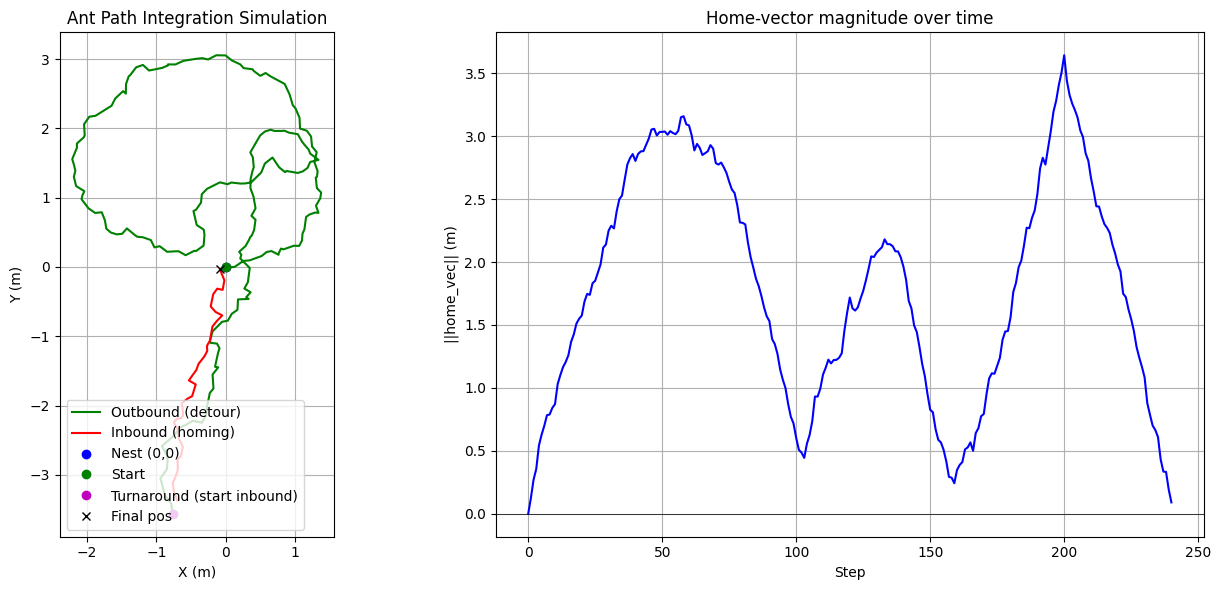

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
dt = 0.1           # timestep
v = 1.0            # speed (m/s)
steps_out = 200    # outbound steps
noise_std = 0.05   # measurement/movement noise
seed = 42          # random seed for reproducibility
max_inbound_steps = 2000  # safety cap to prevent infinite loops
homing_stop_radius = 0.1  # stop when within this distance to nest

np.random.seed(seed)

# Initialize
pos = np.array([0.0, 0.0])
# home_vec initialized to zero; updating with home_vec -= delta_d makes
# home_vec = -pos during perfect integration (vector pointing from ant to nest)
home_vec = np.array([0.0, 0.0])

path_out = [pos.copy()]
path_in = []
home_vec_history = [home_vec.copy()]  # record at every step (both outbound & inbound)
pos_history = [pos.copy()]            # full position history (for plotting)
phase_history = ['outbound']          # track phase labels

# Outbound: scripted detour (circle then noisy random walk)
heading = 0.0
for t in range(steps_out):
    # Detour: circle for first 100 steps, then random changes
    if t < 100:
        heading += np.pi / 50  # steady turn (circle-ish)
    else:
        heading += np.random.normal(0, 0.3)  # noisy heading change

    dx = v * np.cos(heading) * dt + np.random.normal(0, noise_std)
    dy = v * np.sin(heading) * dt + np.random.normal(0, noise_std)
    delta_d = np.array([dx, dy])

    pos += delta_d
    home_vec -= delta_d  # path integration: subtract displacement from home vector

    path_out.append(pos.copy())
    home_vec_history.append(home_vec.copy())
    pos_history.append(pos.copy())
    phase_history.append('outbound')

# Record peak home-vector magnitude observed so far (outbound+inbound later)
# Inbound: head to nest guided by home_vec (heading = atan2(home_vec))
inbound_steps = 0
while np.linalg.norm(pos) > homing_stop_radius and inbound_steps < max_inbound_steps:
    # Heading is direction of the home vector (points to nest)
    heading = np.arctan2(home_vec[1], home_vec[0])

    dx = v * np.cos(heading) * dt + np.random.normal(0, noise_std)
    dy = v * np.sin(heading) * dt + np.random.normal(0, noise_std)
    delta_d = np.array([dx, dy])

    pos += delta_d
    home_vec -= delta_d

    path_in.append(pos.copy())
    home_vec_history.append(home_vec.copy())
    pos_history.append(pos.copy())
    phase_history.append('inbound')

    inbound_steps += 1

# Convert to arrays
path_out = np.array(path_out)
path_in = np.array(path_in)
pos_history = np.array(pos_history)
home_vec_history = np.array(home_vec_history)

# Final statistics
final_error = np.linalg.norm(pos)  # distance to nest at end
peak_home_vec = np.max(np.linalg.norm(home_vec_history, axis=1))
print("Final position error (distance to nest):", final_error)
print("Peak home vector magnitude (max over sim):", peak_home_vec)
print("Inbound steps taken:", inbound_steps)
if inbound_steps >= max_inbound_steps:
    print("Warning: inbound reached max steps; consider increasing max_inbound_steps or reducing noise.")

# Plot trajectories and home-vector magnitude over time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Trajectory plot
ax1.plot(path_out[:, 0], path_out[:, 1], 'g-', label='Outbound (detour)')
if len(path_in) > 0:
    ax1.plot(path_in[:, 0], path_in[:, 1], 'r-', label='Inbound (homing)')
ax1.plot(0, 0, 'bo', label='Nest (0,0)')
ax1.plot(path_out[0, 0], path_out[0, 1], 'go', label='Start')
ax1.plot(path_out[-1, 0], path_out[-1, 1], 'mo', label='Turnaround (start inbound)')
ax1.plot(pos[0], pos[1], 'kx', label='Final pos')
ax1.set_aspect('equal', 'box')
ax1.set_title('Ant Path Integration Simulation')
ax1.set_xlabel('X (m)')
ax1.set_ylabel('Y (m)')
ax1.grid(True)
ax1.legend()

# Home-vector magnitude over steps
hv_mag = np.linalg.norm(home_vec_history, axis=1)
steps = np.arange(len(hv_mag))
ax2.plot(steps, hv_mag, '-b')
ax2.axhline(0, color='k', linewidth=0.5)
ax2.set_title('Home-vector magnitude over time')
ax2.set_xlabel('Step')
ax2.set_ylabel('||home_vec|| (m)')
ax2.grid(True)

plt.tight_layout()
plt.savefig('ant_simulation_improved.png', dpi=150)
plt.show()